In [165]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import thinkstats2
import thinkplot
from collections import Counter
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, mean_squared_error, confusion_matrix, precision_score, recall_score
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SVMSMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import binarize

# Assignment 4 - Classification

For this assignment, you'll need to perform a classification on a dataset, as well as do some prep work on the data. 

The exact steps of what you need to do are flexible and up to you to some degree, however you should consider some of the important things we've mentioned recently, such as:
<ul>
<li> Is the target balanced?
<li> Are there missing or erroneous values?
<li> Are there categorical or numerical features?
<li> Is there colinearity?
<li> Are there outliers?
<li> Should we normalize? 
<li> Do the distributions of the features give any indication that some may need work? 
</ul>

Basically, the data is in the original, potentially dirty, format, and you need to find what should be cleaned, and do the cleaning. There is not one "right" answer to what has to be done, and you'll probably need to do it with at least something of an iterative process - find an issue, correct it, check the data, repeat.

<b>The target that we are predicting is the loan_status. </b>

## Grading

The grades will be broken down as follows:
<ul>
<li> <b>30%</b> - a working predictive model with a reasonable level of accuracy. 
    <ul>
    <li> For the accuracy part, it will not be explicitly graded, but compared to all the others. If you're in the same general range, that's good - if yours is drastically less accurate (or, I guess more accurate), then I'll adjust. There won't be a comparison of "this person is 72.3% and this person is only 71.8% accurate, they fail."
    <li> This data is larger than most of the small sample sets, so random variations due to train-test splits shouldn't be too bad. (If you're a keener you could loop)
    <li> I will use the F1 score as the accuracy metric. 
    </ul>
<li> <b>40%</b> - a clear and readable description of what steps you took to prepare the data, and a brief not on the rationale behind it. Did you do a log transformation to a skewed feature, did you remove outliers, did you remove a feature that has a lot of missing values? Please put this somewhere obvious and readable, consider the goal of the assignment to explain your process to me. 
    <ul>
    <li> E.g. "The target data was imbalanced, so I tried several resampling methods and chose the one with the highest accuracy of the resulting model", "the feature X had the same value for 95% of records, so I dropped it". 
    <li> In this, please also state if you see a group that appears to be a good credit risk, and a group that is a bad credit risk, and indicate the evidence showing that. Please do this other than the most simplistic way - more money = better credit. If there are no such groups, state why you think this. This will likely be about 3 - 5 statements or points, you should provide evidence from the data, but it does not need to be an essay. (You may want to consider this question after you're pretty much done with the data prep and modelling.)
    </ul>
<li> <b>30%</b> - allowing your model to be "deployed". At the bottom of this file there is a small block of code to load in some test data (that I have), and calculate your accuracy. Your contribution to this part is to have a model that is ready to make predictions. Some specifics to consider:
    <ul>
    <li> The test data will be in exactly the same format as the dataset you're given. So any steps that you took to prepare your data for modelling will need to be mirroed here, so the new  data can be predicted. The easiest way to do this is to use a pipeline, but it is up to you. Remember the model only accepts data that is in a certain format - the one that you had the data in when it was trained, so when making predictions you need to make sure that is true. 
    <li> Since I'm providing test data, and your task is to just create a model, think about how that might impact your train-test splitting, both as you're developing and for the final product. 
    <li> Once the model is trained it should predict any data that is in the right format, so I should be able to provide any proper dataset, click run on that testing cell, and get predictions. I will not be doing anything that will purposefully make this harder or trickier, like including data that has errors or is in the wrong format, I just split the entire set of data, reserved part of it to test accuracy, and gave the rest to you. Things that you've changed (e.g. dropping a column, one-hot encoding) do need to be replicated at some point before the model can accept the new data to predict. In general we <b>do</b> want to check in our processing that our input is valid, this is kind of a junior introduction to that. 
    </ul>
</ul

## Load Credit Data

In [154]:
df = pd.read_csv("train.csv")
df.sample(10)

,Unnamed: 0,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length
3351,9962,24,65000,MORTGAGE,8.0,PERSONAL,B,10000,11.99,0,0.15,N,4
19462,4092,21,40000,OWN,0.0,EDUCATION,C,2500,14.27,0,0.06,N,2
8458,6475,25,50000,OWN,2.0,HOMEIMPROVEMENT,B,20000,11.71,0,0.40,N,4
3696,31328,37,87950,MORTGAGE,3.0,EDUCATION,B,14250,11.89,0,0.16,N,14
20755,32534,76,75000,RENT,23.0,MEDICAL,A,15000,8.94,0,0.20,N,25
10058,28728,33,40000,RENT,17.0,EDUCATION,D,11175,14.96,0,0.28,Y,5
12530,8289,24,57000,MORTGAGE,8.0,HOMEIMPROVEMENT,B,19725,9.99,0,0.35,N,2
1920,16897,23,75000,RENT,3.0,PERSONAL,B,10000,11.86,0,0.13,N,2
11102,7544,21,53851,MORTGAGE,2.0,DEBTCONSOLIDATION,B,12000,10.00,0,0.22,N,2
8988,19707,34,30000,RENT,4.0,VENTURE,B,3350,10.99,0,0.11,N,10


In [155]:
df.describe()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,26064.000000,26064.000000,2.606400e+04,25350.000000,26064.000000,23575.000000,26064.000000,26064.000000,26064.000000
mean,16307.473258,27.738375,6.602795e+04,4.791440,9595.886088,11.006839,0.216812,0.170264,5.805210
std,9396.129345,6.381305,6.265098e+04,4.100277,6321.894580,3.245217,0.412082,0.106673,4.055158
min,0.000000,20.000000,4.080000e+03,0.000000,500.000000,5.420000,0.000000,0.000000,2.000000
25%,8202.250000,23.000000,3.879375e+04,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,16324.500000,26.000000,5.500000e+04,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,24458.250000,30.000000,7.920000e+04,7.000000,12200.000000,13.470000,0.000000,0.230000,8.000000
max,32580.000000,144.000000,6.000000e+06,123.000000,35000.000000,23.220000,1.000000,0.830000,30.000000


### Filter the Outliers

In [156]:
# Removing the high value outliers to make the data into usable scales
df = df[df['person_age'] < 50]
df = df[df['person_income'] < 1.5e+05]
# remove any missing values in the dataframe
df.dropna(axis=0, inplace=True)
df.describe()

,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
count,21783.000000,21783.000000,21783.000000,21783.000000,21783.000000,21783.000000,21783.000000,21783.000000,21783.000000
mean,16000.630538,27.319791,59773.974705,4.720286,9392.791397,11.024665,0.220493,0.173324,5.566405
std,9236.588993,5.413939,28178.378450,4.018966,6068.773351,3.230387,0.414589,0.106565,3.623674
min,0.000000,20.000000,4080.000000,0.000000,500.000000,5.420000,0.000000,0.010000,2.000000
25%,8001.500000,23.000000,38400.000000,2.000000,5000.000000,7.900000,0.000000,0.090000,3.000000
50%,15881.000000,26.000000,54990.000000,4.000000,8000.000000,10.990000,0.000000,0.150000,4.000000
75%,23985.500000,30.000000,75000.000000,7.000000,12000.000000,13.480000,0.000000,0.230000,8.000000
max,32296.000000,49.000000,149981.000000,123.000000,35000.000000,23.220000,1.000000,0.830000,17.000000


### Correlation Analysis

In [157]:
# creating the correlations matrix to check for multicolinearity
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\atrsy\AppData\Local\Temp\ipykernel_17688\909706826.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,Unnamed: 0,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,cb_person_cred_hist_length
Unnamed: 0,1.00,0.78,0.24,0.19,0.09,-0.01,-0.07,-0.06,0.79
person_age,0.78,1.00,0.09,0.17,0.03,0.00,-0.03,-0.03,0.86
person_income,0.24,0.09,1.00,0.19,0.38,-0.03,-0.24,-0.33,0.07
person_emp_length,0.19,0.17,0.19,1.00,0.10,-0.06,-0.08,-0.04,0.15
loan_amnt,0.09,0.03,0.38,0.10,1.00,0.14,0.13,0.64,0.02
loan_int_rate,-0.01,0.00,-0.03,-0.06,0.14,1.00,0.34,0.13,0.01
loan_status,-0.07,-0.03,-0.24,-0.08,0.13,0.34,1.00,0.38,-0.02
loan_percent_income,-0.06,-0.03,-0.33,-0.04,0.64,0.13,0.38,1.00,-0.02
cb_person_cred_hist_length,0.79,0.86,0.07,0.15,0.02,0.01,-0.02,-0.02,1.00


In [158]:
# Likely want to drop cb_person_cred_hist_length due to high colinearity
# Likely also drop the unnamed 0 column due to colinearity with person_age
df = df.drop(columns='cb_person_cred_hist_length')
df = df.drop(columns='Unnamed: 0')

In [159]:
# Re-checking the correlations
corr = df.corr()
corr.style.background_gradient()
corr.style.background_gradient().set_precision(2)

C:\Users\atrsy\AppData\Local\Temp\ipykernel_17688\1003654234.py:4: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.background_gradient().set_precision(2)


,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income
person_age,1.00,0.09,0.17,0.03,0.00,-0.03,-0.03
person_income,0.09,1.00,0.19,0.38,-0.03,-0.24,-0.33
person_emp_length,0.17,0.19,1.00,0.10,-0.06,-0.08,-0.04
loan_amnt,0.03,0.38,0.10,1.00,0.14,0.13,0.64
loan_int_rate,0.00,-0.03,-0.06,0.14,1.00,0.34,0.13
loan_status,-0.03,-0.24,-0.08,0.13,0.34,1.00,0.38
loan_percent_income,-0.03,-0.33,-0.04,0.64,0.13,0.38,1.00


### One-Hot Encoding

In [160]:
# turn object columns into category types to ensure proper encoding
df['person_home_ownership'] = df['person_home_ownership'].astype('category')
df['loan_intent'] = df['loan_intent'].astype('category')
df['loan_grade'] = df['loan_grade'].astype('category')

In [161]:
# One-Hot Encoding, with drop first enabled to avoid phantom categories
df = pd.get_dummies(df, drop_first=True)
df.sample(10)

,person_age,person_income,person_emp_length,loan_amnt,loan_int_rate,loan_status,loan_percent_income,person_home_ownership_OTHER,person_home_ownership_OWN,person_home_ownership_RENT,...,loan_intent_MEDICAL,loan_intent_PERSONAL,loan_intent_VENTURE,loan_grade_B,loan_grade_C,loan_grade_D,loan_grade_E,loan_grade_F,loan_grade_G,cb_person_default_on_file_Y
1823,21,30000,0.0,5000,8.59,0,0.17,0,0,1,...,0,0,1,0,0,0,0,0,0,0
1900,33,86000,0.0,4700,9.63,0,0.05,0,0,1,...,0,0,0,0,0,0,0,0,0,0
8364,26,67150,9.0,15000,14.11,1,0.19,0,0,0,...,1,0,0,0,0,1,0,0,0,1
9025,21,50000,4.0,7000,15.27,0,0.14,0,0,1,...,1,0,0,0,1,0,0,0,0,1
23866,23,55000,4.0,4000,12.53,0,0.07,0,0,1,...,1,0,0,1,0,0,0,0,0,0
12665,23,75000,4.0,7500,11.83,0,0.10,0,0,1,...,0,0,0,1,0,0,0,0,0,0
6762,26,18144,2.0,2675,9.91,0,0.15,0,0,1,...,0,1,0,1,0,0,0,0,0,0
10235,25,78500,2.0,12000,10.99,0,0.15,0,0,1,...,1,0,0,1,0,0,0,0,0,0
13345,32,54000,9.0,13000,12.53,0,0.24,0,0,0,...,0,0,1,0,1,0,0,0,0,1
25638,24,35000,9.0,8000,11.71,0,0.23,0,0,0,...,0,0,0,1,0,0,0,0,0,0


### Data Balance Checking and Correcting

In [166]:
# Show imbalance in the data
print(df['loan_status'].value_counts())

# data appears to be a 3:1 ratio of 1 to 0
# resample our training sets using ADASYN to create a balance
sampler = SVMSMOTE(n_jobs=-1)
y = np.array(df["loan_status"]).reshape(-1,1)
x = np.array(df.drop(columns={"loan_status"}))

xTrain, xTest, yTrain, yTest = train_test_split(x, y, test_size=0.33)

#Look at relative imbalance after split
xTrainSamp, yTrainSamp = sampler.fit_resample(xTrain, yTrain)
print('Resampled dataset shape:', Counter(yTrainSamp))

#Normalize data
scaler = StandardScaler()
xTrainNorm = scaler.fit_transform(xTrainSamp)
xTestNorm = scaler.transform(xTest)

0    16980
1     4803
Name: loan_status, dtype: int64
Resampled dataset shape: Counter({1: 11300, 0: 11300})


### Modelling

F1: 0.6427003293084523
Acc: 0.818889970788705
Recall: 0.7760106030483764
Precision: 0.5484777517564403


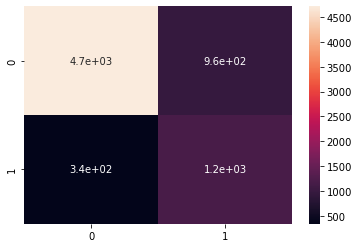

In [168]:
#Train model
model = LogisticRegression(max_iter=10000, n_jobs=-1).fit(xTrainNorm,yTrainSamp.ravel())

#Make predictions
preds = model.predict(xTestNorm)

#Generate 1/0 results and show results
labels = binarize(np.array(preds).reshape(-1,1), threshold=.5)
conf_matrix = confusion_matrix(yTest,labels)
sns.heatmap(conf_matrix, annot=True)

print("F1:",f1_score(yTest, labels))
print("Acc:",accuracy_score(yTest, labels))
print("Recall:",recall_score(yTest, labels))
print("Precision:",precision_score(yTest, labels))

### Accuracy Test

Replace the green part with whatever you need to transform the fresh data into the format needed for your model to predict. 

<b>Note:</b> you could test and make sure that things are working OK here by taking part of your dataset, saving it in a separate CSV, and running it through here as a piece of test data. The accuracy results would be useless, but you'd confirm that the model works properly. 

In [3]:
d_test = pd.read_csv("test.csv")

######################
# Insert whatever you need to do to prep the data here. 
# It might be nothing if you have a big pipeline. 
# Ensure that at the end your data is in two arrays - xtest and ytest
# Ensure the name of your final model is "model"
# Each should contain the ENTIRE x or y dataset in the test data. 
#
# This part should be reusable - any dataset in this format should just run
# and generate predictions and accuracy stats. 
# Please DO NOT do any train-test splitting here. 
#######################

# This should work once you're done, as is. 
# uncomment the stuff below when ready to run.
#print("F1:",f1_score(ytest, prediction_labels))
#conf_matrix = confusion_matrix(ytest, prediction_labels)
#sns.heatmap(conf_matrix, annot=True)